#### Preludio

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn.objects as so
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import sympy as sp
import ipywidgets as iwy

difraccion = lambda p, a, b, p0, c: (-1 / ((a / (p0 - p)**2) + b)**0.5) + c

difraccion_a = lambda p, a, b, p0: -a/((p - p0)**2*(a**2/(p - p0)**2 + b**2)**1.5)
difraccion_b = lambda p, a, b, p0: -b/(a**2/(p - p0)**2 + b**2)**1.5
difraccion_p0 = lambda p, a, b, p0: -a**2/((p - p0)**3*(a**2/(p - p0)**2 + b**2)**1.5)

def propagacion(funcion, x, popt, pcov):
    n_params = funcion.__code__.co_argcount
    params = sp.symbols(funcion.__code__.co_varnames[:n_params])

    funcion_sympy = funcion(*params)

    derivadas = []
    for i in range(1, n_params):
        derivada = sp.lambdify(params, sp.diff(funcion_sympy, params[i]).simplify())
        derivadas.append(derivada(x, *popt))

    error = np.zeros(len(x))
    for i in range(n_params-1):
        for j in range(i, n_params-1):
            error += derivadas[i]*derivadas[j]*pcov[i, j]*(2**(i!=j))

    return error

In [88]:
from os.path import exists
if not exists("./led_nuevo/"):
  !pip install -q gdown
  from gdown import download_folder
  id = '1OSF4tJr5D3Jrdt2ujON82j-QHYnGnUfN'
  download_folder(f'https://drive.google.com/drive/folders/{id}', quiet=False, use_cookies=False)

#### Espectro thorlabs

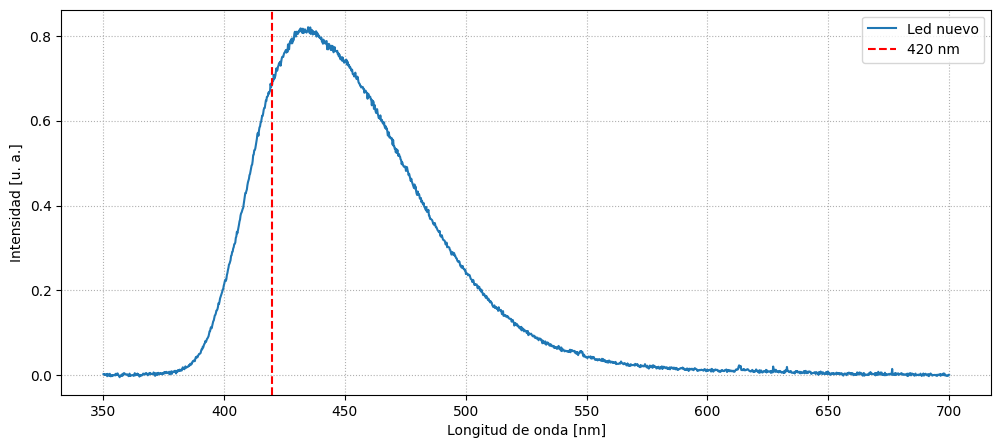

In [89]:
ldo, i = np.loadtxt('led_nuevo/led_nuevo_thorlabs.csv', delimiter=',', skiprows=53, unpack=True)
i = i[(ldo <= 700) & (ldo >= 350)]
ldo = ldo[(ldo <= 700) & (ldo >= 350)]

plt.figure(figsize=(12,5))
plt.plot(ldo, i, label='Led nuevo')
plt.xlabel('Longitud de onda [nm]')
plt.ylabel('Intensidad [u. a.]')
plt.axvline(420, color='r', linestyle='--', label='420 nm')
plt.legend()
plt.grid(ls=':')
plt.show()

#### Espectro celular

###### Calibración

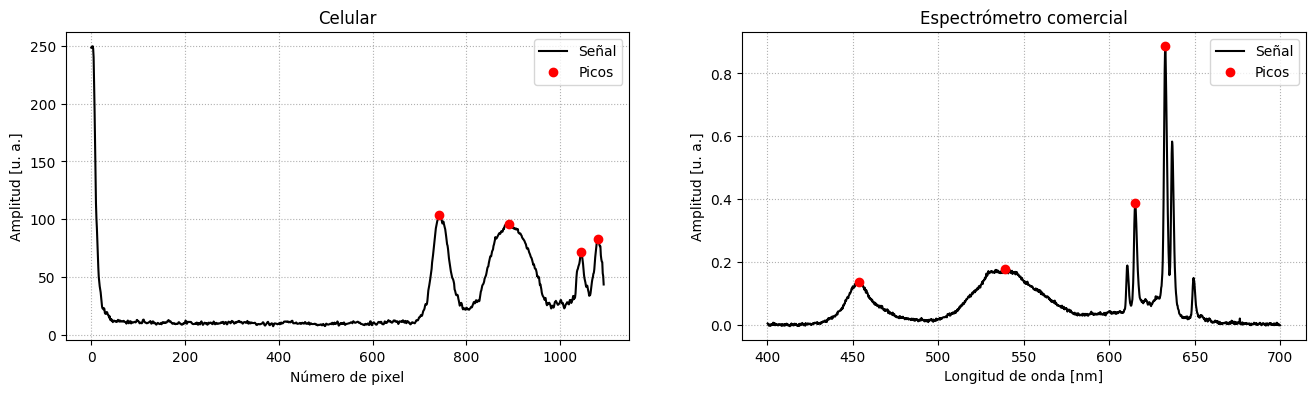

In [90]:
# DATOS
# Celular
df_c = pd.read_csv('./led_nuevo/celu.csv')

px_c = df_c['Distance_(pixels)']
a_c = df_c['Gray_Value']

# Espectrometro
l_e, a_e = np.loadtxt('./led_nuevo/pantalla_espectrometro.txt',
                      delimiter=',', unpack=True)

a_e = a_e[(l_e >= 400) & (l_e <= 700)]
l_e = l_e[(l_e >= 400) & (l_e <= 700)]

# PICOS
# peaks_c, *_ = find_peaks(a_c, prominence=0.05)
peaks_c, *_ = find_peaks(a_c, prominence=25, height=50)
# peaks_e, *_ = find_peaks(a_e, prominence=0.12)  # Solo picos rojos
peaks_e, *_ = find_peaks(a_e, prominence=0.12, distance=75)  # Todos los picos

# GRAFICO
fig, ax = plt.subplots(1, 2, figsize=(16,4))

ax[0].plot(px_c, a_c, 'k', label='Señal')
ax[0].plot(px_c[peaks_c], a_c[peaks_c], 'or', label='Picos')
ax[0].set_xlabel('Número de pixel')
ax[0].set_title('Celular')
# ax[0].set_xlim(600, 1300)

ax[1].plot(l_e, a_e, 'k', label='Señal')
ax[1].plot(l_e[peaks_e], a_e[peaks_e], 'or', label='Picos')
ax[1].set_xlabel('Longitud de onda [nm]')
ax[1].set_title('Espectrómetro comercial')

for ax_i in ax:
    ax_i.grid(ls=':')
    ax_i.legend()
    ax_i.set_ylabel('Amplitud [u. a.]')
plt.show()

<ipython-input-94-4106490898>:5: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(difraccion, picos_celu, picos_espec, maxfev=1000000,


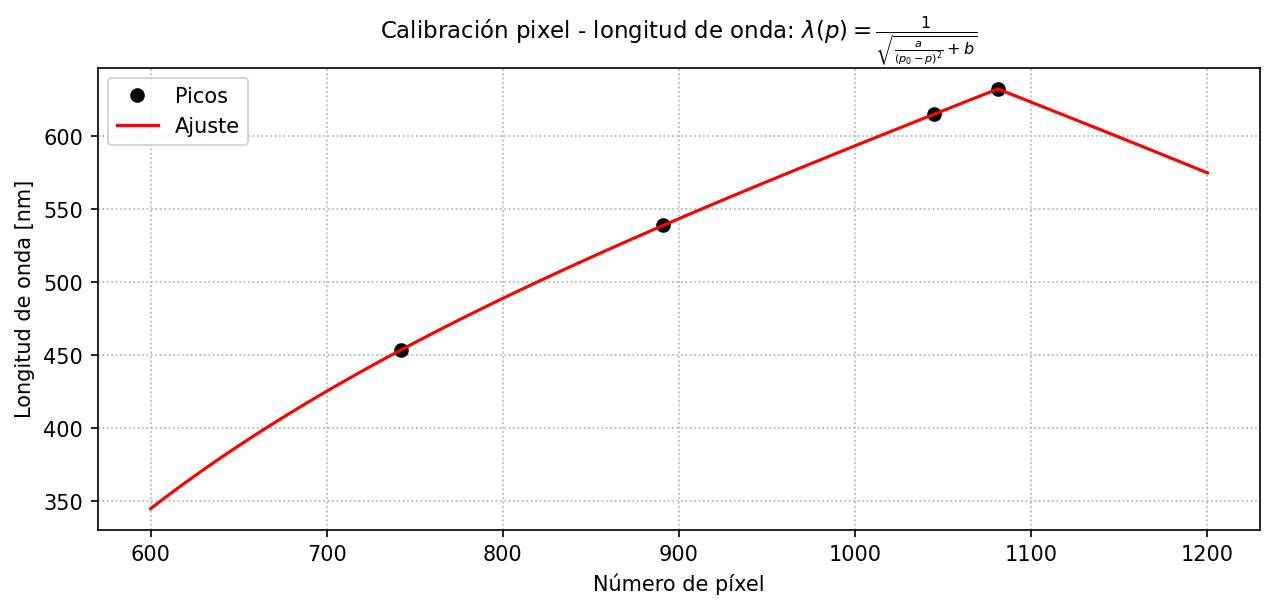

In [94]:
# AJUSTE
picos_celu = px_c[peaks_c]
picos_espec = l_e[peaks_e]

popt, pcov = curve_fit(difraccion, picos_celu, picos_espec, maxfev=1000000,
                       p0=[1.26777218, 6.78704522e-13, 2e3, 200])

# GRAFICO
fig, ax = plt.subplots(figsize=(10, 4), dpi=150)
ax.set_title(r'Calibración pixel - longitud de onda: $\lambda(p) = \frac{1}{\sqrt{\frac{a}{(p_0 - p)^2} + b}}$', fontsize=11)
ax.set_xlabel('Número de píxel')
ax.set_ylabel('Longitud de onda [nm]')

ax.plot(picos_celu, picos_espec, 'ok', label='Picos')
# ax.errorbar(picos_celu, picos_espec, yerr=[1]*len(picos_celu),
#             xerr=np.std(px_para_picos, axis=0, ddof=1)[::-1],
#             fmt='ok', label='Picos', capsize=2, capthick=1)

xfino = np.linspace(np.min(picos_celu), np.max(picos_celu), 1000)
xfino = np.linspace(600, 1200, 10000)
yfino = difraccion(xfino, *popt)
ax.plot(xfino, yfino, 'r-', label='Ajuste')
# errores = propagacion(difraccion, xfino, popt, pcov)
# ax.fill_between(xfino, yfino-errores, yfino+errores, color='r', alpha=0.3, label='Error ajuste')

ax.grid(ls=':')
ax.legend()
plt.show()

###### Gráfico

<ipython-input-87-760233703>:10: RuntimeWarning: invalid value encountered in sqrt
  difraccion = lambda p, a, b, p0, c: (-1 / ((a / (p0 - p)**2) + b)**0.5) + c


,Distance_(pixels),Gray_Value,longitud de onda
0,0,248.360,NaN
1,1,248.726,NaN
2,2,248.811,NaN
3,3,249.638,NaN
4,4,247.654,NaN
...,...,...,...
1089,1089,63.391,628.823666
1090,1090,62.864,628.344643
1091,1091,53.256,627.865601
1092,1092,50.743,627.386536


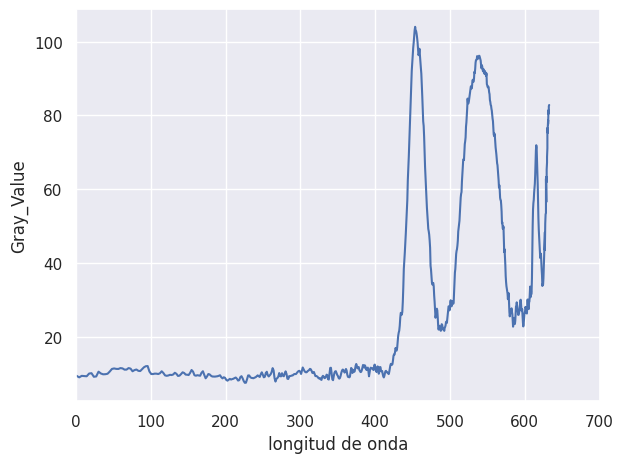

In [92]:
df = pd.read_csv('./led_nuevo/celu.csv')

# df['Distance_(pixels)'] df['Gray_Value']

df['longitud de onda'] = difraccion(np.array(df['Distance_(pixels)']), *popt)

display(df)

# x = 'Distance_(pixels)'
x = 'longitud de onda'

(
    so.Plot(df)
    .add(so.Line(), x=x, y='Gray_Value')
    .limit(x=(0, 700))
    .show()
)

<ipython-input-87-760233703>:10: RuntimeWarning: invalid value encountered in sqrt
  difraccion = lambda p, a, b, p0, c: (-1 / ((a / (p0 - p)**2) + b)**0.5) + c


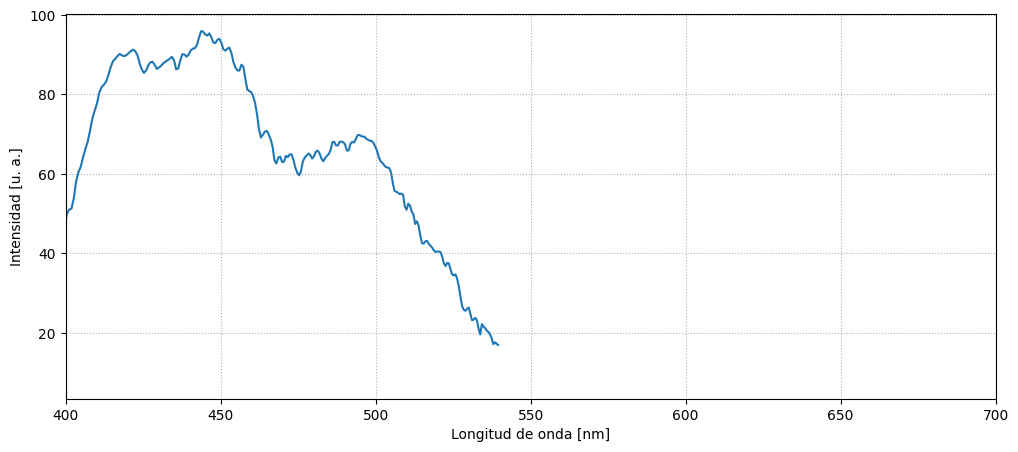

In [93]:
df = pd.read_csv('./led_nuevo/led.csv')
px = df['Distance_(pixels)'].to_numpy()
i = df['Gray_Value'].to_numpy()
ldo = difraccion(px, *popt)

plt.figure(figsize=(12,5))
plt.plot(ldo, i, label='Led nuevo')
plt.xlabel('Longitud de onda [nm]')
plt.ylabel('Intensidad [u. a.]')
# plt.axvline(420, color='r', linestyle='--', label='420 nm')
# plt.legend()
plt.xlim(400, 700)
plt.grid(ls=':')
plt.show()